In [1]:
import torch.nn.functional as F
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def norm_np_img(data):
    return data.astype(float) / 255.

In [3]:
def load_data_from_csv(file_name, y_column, batch_size=32, valid_size=0.25):
    import pandas as pd
    
    df = pd.read_csv(file_name).astype(float)
    df = df.sample(frac=1)  # shuffle dataframe
    train_size, valid_size = int(df.shape[0]*(1-valid_size)), int(df.shape[0]*(valid_size))
    print(f"train size = {train_size}, validation size = {valid_size}")
    
    y_train_np_data, y_valid_np_data = df[y_column].head(train_size).values, df[y_column].tail(valid_size).values
    x_train_np_data, x_valid_np_data = (df.drop(columns=[y_column]).head(train_size).values, 
                                        df.drop(columns=[y_column]).tail(valid_size).values)
    
    x_train_np_data, x_valid_np_data = norm_np_img(x_train_np_data), norm_np_img(x_valid_np_data)
    print(f"X train shape = {x_train_np_data.shape}, Y train shape = {y_train_np_data.shape}")
    
    y_train_tensor, y_valid_tensor = torch.from_numpy(y_train_np_data), torch.from_numpy(y_valid_np_data)
    x_train_tensor, x_valid_tensor = torch.from_numpy(x_train_np_data), torch.from_numpy(x_valid_np_data)
    
    tensor_ds_train = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)  # create TRAIN tensor dataset
    tensor_ds_valid = torch.utils.data.TensorDataset(x_valid_tensor, y_valid_tensor)  # create VALID tensor dataset
    
    tensor_dl_train = torch.utils.data.DataLoader(tensor_ds_train, batch_size=batch_size, shuffle=True)
    tensor_dl_valid = torch.utils.data.DataLoader(tensor_ds_valid, batch_size=batch_size*2)
    
    return (tensor_dl_train, tensor_dl_valid)

## Create dataloader with GPU

In [4]:
class CudaLoader:
    # Iterable obj
    
    def __init__(self, DataLoader):
        self.dl = DataLoader
        self.dev = torch.device(0) if torch.cuda.is_available() else torch.device('cpu')
        print('Device is', self.dev)
    
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        iter_dl = iter(self.dl)
        for xb, yb in iter_dl:
            yield self.preprocess(xb, yb)
    
    def preprocess(self, xb, yb):
        return xb.view(-1, 1, 28, 28).to(self.dev), yb.view(-1, 1).to(self.dev)

In [5]:
train_dl, valid_dl = load_data_from_csv('mnist_dataset\\train.csv', y_column='label', batch_size=64)

train size = 31500, validation size = 10500
X train shape = (31500, 784), Y train shape = (31500,)


In [6]:
train_cdl, valid_cdl = CudaLoader(train_dl), CudaLoader(valid_dl)

Device is cuda:0
Device is cuda:0


## Init model

In [84]:
class CNN_Net(torch.nn.Module):
    
    def __init__(self, output_size):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(32*3*3, 32)  # bad value - 18432
        self.out = nn.Linear(32, output_size)
    
    def forward(self, x):
        c1 = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        c2 = F.max_pool2d(F.relu(self.conv2(c1)), (2, 2))
        c3 = F.max_pool2d(F.relu(self.conv3(c2)), (2, 2))
        
        c3 = c3.view(-1, 32*3*3)
        f1 = F.relu(self.fc1(c3))
        out = self.out(f1)
        return out

In [115]:
model = CNN_Net(output_size=10).double().cuda()
optim = torch.optim.Adam(model.parameters(), lr=2e-4)

In [101]:
loss_func = nn.CrossEntropyLoss()

In [102]:
def accuracy(pred_tensor, target):
    classes = torch.argmax(pred_tensor, dim=1)
    equal_classes = (classes == target.squeeze(1)).float()
    return torch.mean(equal_classes)

## Train model

In [113]:
def train(model, epochs, optimizer, loss_func, train_loader, valid_loader=None):
    train_history = [[], []]
    valid_history = [[], []]
    for ep in range(epochs):
        ep_train_loss, ep_train_acc = [], []
        
        for xb, yb in train_loader:
            optimizer.zero_grad()
            
            preds = model(xb)
            loss = loss_func(preds, yb.long().squeeze(1))
            loss.backward()
            optimizer.step()
            
            acc = accuracy(preds, yb).item()
            ep_train_acc.append(acc)
            ep_train_loss.append(loss.item())
        # mean accuracy and loss for current epoch
        train_history[0].append(np.array(ep_train_acc).mean())
        train_history[1].append(np.array(ep_train_loss).mean())
        
        if valid_loader is not None:
            with torch.no_grad():
                eval_acc, eval_loss = [], []
                for xb, yb in valid_loader:
                    preds = model(xb)
                    eval_loss.append(loss_func(preds, yb.long().squeeze(1)).item())
                    eval_acc.append(accuracy(preds, yb).item())
                # mean accuracy and loss for current epoch with validation data
                valid_history[0].append(np.array(eval_acc).mean())
                valid_history[1].append(np.array(eval_loss).mean())
                
        print(f'Eposh {ep}. acc:', round(np.array(ep_train_acc).mean(), 5), 'loss:', round(np.array(ep_train_loss).mean(), 5))
    
    return train_history, valid_history

In [116]:
train_hist, valid_hist = train(model, epochs=40, optimizer=optim, loss_func=loss_func, train_loader=train_cdl, valid_loader=valid_cdl)

Eposh 0. acc: 0.5762 loss: 1.35609
Eposh 1. acc: 0.88236 loss: 0.40216
Eposh 2. acc: 0.91598 loss: 0.28324
Eposh 3. acc: 0.93153 loss: 0.22883
Eposh 4. acc: 0.94127 loss: 0.19664
Eposh 5. acc: 0.94592 loss: 0.17333
Eposh 6. acc: 0.95195 loss: 0.15858
Eposh 7. acc: 0.95499 loss: 0.14476
Eposh 8. acc: 0.95892 loss: 0.13427
Eposh 9. acc: 0.96146 loss: 0.12631
Eposh 10. acc: 0.96232 loss: 0.11941
Eposh 11. acc: 0.96545 loss: 0.11265
Eposh 12. acc: 0.96663 loss: 0.10679
Eposh 13. acc: 0.96773 loss: 0.10333
Eposh 14. acc: 0.9698 loss: 0.09748
Eposh 15. acc: 0.97116 loss: 0.09383
Eposh 16. acc: 0.9717 loss: 0.09013
Eposh 17. acc: 0.97308 loss: 0.08785
Eposh 18. acc: 0.97401 loss: 0.08321
Eposh 19. acc: 0.97563 loss: 0.08041
Eposh 20. acc: 0.97603 loss: 0.0784
Eposh 21. acc: 0.97718 loss: 0.07534
Eposh 22. acc: 0.97762 loss: 0.07287
Eposh 23. acc: 0.97794 loss: 0.07069
Eposh 24. acc: 0.97856 loss: 0.06817
Eposh 25. acc: 0.9799 loss: 0.06663
Eposh 26. acc: 0.98062 loss: 0.06501
Eposh 27. acc: 0

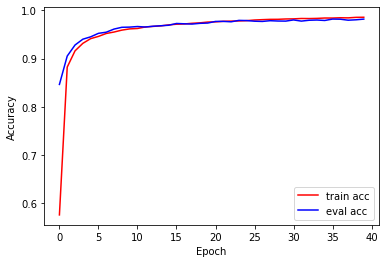

In [117]:
plt.plot(train_hist[0], label='train acc', color='red')
plt.plot(valid_hist[0], label='eval acc', color='blue')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

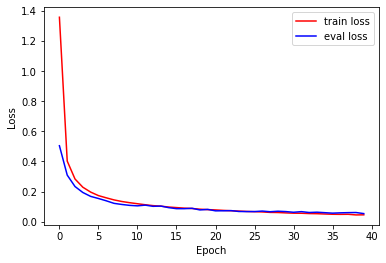

In [118]:
plt.plot(train_hist[1], label='train loss', color='red')
plt.plot(valid_hist[1], label='eval loss', color='blue')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [120]:
torch.save(model, 'cnn_model.pt')

In [121]:
iter_cdl = iter(valid_cdl)
xb_val, yb_val = next(iter_cdl)

## Predict some examples from validation dataset

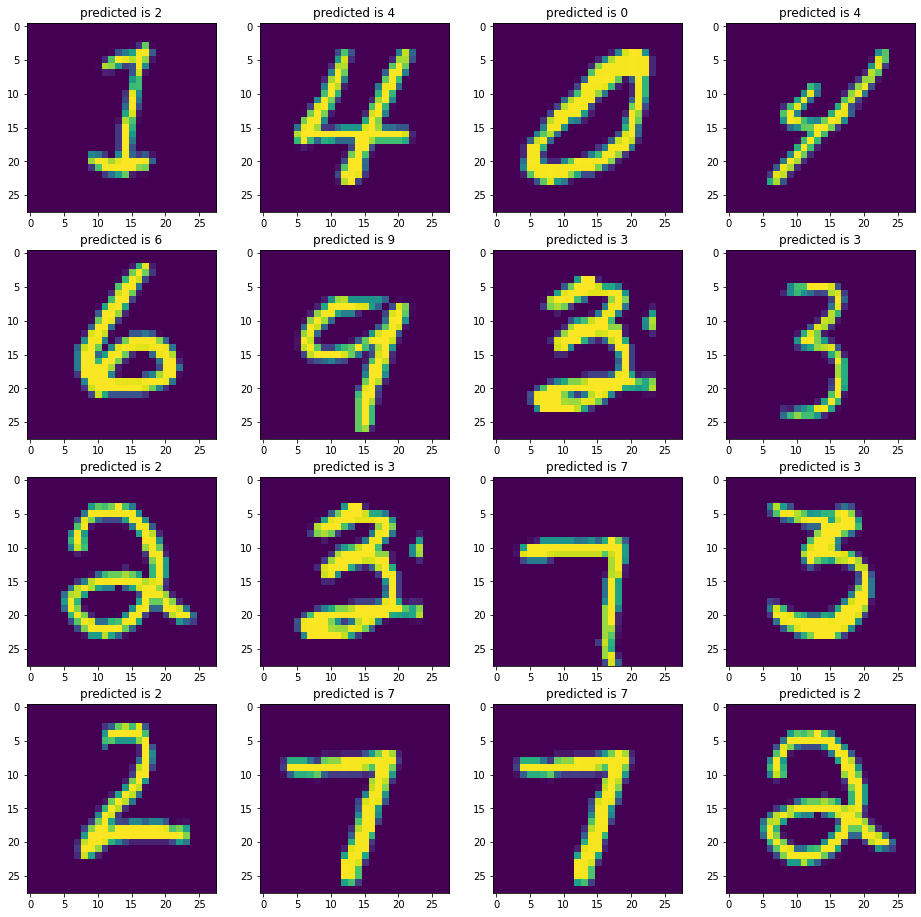

In [142]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))
for row_i in range(4):
    for col_j in range(4):
        random_index = np.random.randint(0, 64)
        axes[row_i][col_j].imshow((xb_val[random_index].view(28, 28).cpu().numpy() * 255).astype(np.uint8))
        pred = torch.argmax(model(xb_val[random_index].view(-1, 1, 28, 28))).item()
        axes[row_i][col_j].set_title('predicted is ' + str(pred))